In [1]:
import pickle as pkl
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from emle.models import EMLE
from emle.train._utils import pad_to_max
from scipy.stats import kendalltau, pearsonr
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

HARTEE_TO_KJ_MOL = 2625.5
KJ_PER_MOL_TO_KCAL_PER_MOL = 1 / 4.184

/home/joaomorado/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [2]:
def calculate_rmse(predicted, reference):
    """
    Calculate the root mean squared error (RMSE) between predicted and reference values.

    Parameters
    ----------
    predicted : numpy.ndarray
        The predicted values.
    reference : numpy.ndarray

    Returns
    -------
    rmse : float
        The root mean squared error.
    """
    return np.sqrt(np.mean((predicted - reference) ** 2))


def compute_metrics(true_values, predicted_values):
    """
    Compute the mean unsigned error (MUE), mean signed error (MSE), Kendall's tau,
    Pearson's correlation, R^2, and root mean squared error (RMSE) between true and predicted values.

    Parameters
    ----------
    true_values : numpy.ndarray
        The true values.
    predicted_values : numpy.ndarray
        The predicted values.

    Returns
    -------
    mue : float
        The mean unsigned error.
    mse : float
        The mean signed error.
    kendall : float
        The Kendall's tau.
    pearson : float
        The Pearson's correlation.
    r2 : float
        The R^2 score.
    rmse : float
        The root mean squared error.
    """

    mue = np.mean(np.abs(predicted_values - true_values))
    mse = np.mean(predicted_values - true_values)
    kendall = kendalltau(true_values, predicted_values)[0]
    pearson = pearsonr(true_values, predicted_values)[0]
    r2 = r2_score(true_values, predicted_values)
    rmse = calculate_rmse(predicted_values, true_values)

    return mue, mse, kendall, pearson, r2, rmse

# Load Data

In [3]:
# Set the path to the models
source_path = "../../../"

models_dict = {
    "QM7-Species": source_path + "emle_models/emle_qm7_aev.mat",
    "QM7-Reference": source_path + "emle_models/emle_qm7_aev.mat",
    "Bespoke-Species-Iter1": source_path + "emle_models/ligand_bespoke_iter1.mat",
    "Bespoke-Reference-Iter1": source_path + "emle_models/ligand_bespoke_iter1.mat",
    "Bespoke-Species-Iter2": source_path + "emle_models/ligand_bespoke_iter2.mat",
    "Bespoke-Reference-Iter2": source_path + "emle_models/ligand_bespoke_iter2.mat",
    "Patched-Species-Iter1": source_path
    + "emle_models/ligand_patched_species_iter1.mat",
    "Patched-Reference-Iter1": source_path
    + "emle_models/ligand_patched_reference_iter1.mat",
    "Patched-Species-Iter2": source_path
    + "emle_models/ligand_patched_species_iter2.mat",
    "Patched-Reference-Iter2": source_path
    + "emle_models/ligand_patched_reference_iter2.mat",
}

# Load the testing data
testing_data_paths = {
    "Iter1": source_path + "data/testing_datasets/testing_data_iter1.pkl",
    "Iter2": source_path + "data/testing_datasets/testing_data_iter2.pkl",
    "Iter3": source_path + "data/testing_datasets/testing_data_iter3.pkl",
}

# Load the testing data
testing_data = {}
for testing_data_name, testing_data_path in testing_data_paths.items():
    data = pkl.load(open(testing_data_path, "rb"))
    xyz_qm = pad_to_max(data["xyz_qm"])
    xyz_mm = pad_to_max(data["xyz_mm"])
    z = pad_to_max(data["z"])
    charges_mm = pad_to_max(data["charges_mm"])
    e_static_ref = torch.tensor(data["e_static"])
    e_ind_ref = torch.tensor(data["e_ind"])
    testing_data[testing_data_name] = {
        "xyz_qm": xyz_qm,
        "xyz_mm": xyz_mm,
        "z": z,
        "charges_mm": charges_mm,
        "e_static_ref": e_static_ref,
        "e_ind_ref": e_ind_ref,
    }


# Calculate EMLE Energies

In [4]:
# Evaluate the EMLE energy for each model
emle_energy_dict = {}

for iteration, data_dict in testing_data.items():
    xyz_qm = data_dict["xyz_qm"]
    xyz_mm = data_dict["xyz_mm"]
    z = data_dict["z"]
    charges_mm = data_dict["charges_mm"]
    e_static_ref = data_dict["e_static_ref"]
    e_ind_ref = data_dict["e_ind_ref"]

    emle_energy_dict[iteration] = {}

    for model_name, model_path in models_dict.items():
        alpha_mode = "species" if "Species" in model_name else "reference"
        emle_model = EMLE(model=model_path, alpha_mode=alpha_mode).double()

        e_static_emle, e_ind_emle = emle_model.forward(
            z,
            charges_mm,
            xyz_qm,
            xyz_mm,
        )

        emle_energy_dict[iteration][model_name] = {
            "e_static_emle": e_static_emle.detach() * HARTEE_TO_KJ_MOL,
            "e_ind_emle": e_ind_emle.detach() * HARTEE_TO_KJ_MOL,
            "e_total_emle": (e_static_emle.detach() + e_ind_emle.detach())
            * HARTEE_TO_KJ_MOL,
        }

# Save the EMLE energy dictionary
# with open("emle_energy_dict_per_iter.pkl", "wb") as f:
#     pkl.dump(emle_energy_dict, f)

In [5]:
# Compute metrics for each model/iteration
metrics_dict = {}
for iteration, data_dict in testing_data.items():
    metrics_dict[iteration] = {}
    for model_name in models_dict.keys():
        # Convert reference energies to numpy and kcal/mol
        e_static_ref = data_dict["e_static_ref"].numpy() * KJ_PER_MOL_TO_KCAL_PER_MOL
        e_ind_ref = data_dict["e_ind_ref"].numpy() * KJ_PER_MOL_TO_KCAL_PER_MOL
        e_total_ref = e_static_ref + e_ind_ref

        # Get EMLE energies and convert to numpy and kcal/mol
        emle_energies = emle_energy_dict[iteration][model_name]
        e_static_emle = (
            emle_energies["e_static_emle"].numpy() * KJ_PER_MOL_TO_KCAL_PER_MOL
        )
        e_ind_emle = emle_energies["e_ind_emle"].numpy() * KJ_PER_MOL_TO_KCAL_PER_MOL
        e_total_emle = (
            emle_energies["e_total_emle"].numpy() * KJ_PER_MOL_TO_KCAL_PER_MOL
        )

        # Compute metrics for each energy component
        energy_types = {
            "e_static": (e_static_ref, e_static_emle),
            "e_ind": (e_ind_ref, e_ind_emle),
            "e_total": (e_total_ref, e_total_emle),
        }

        metrics_dict[iteration][model_name] = {}
        for energy_type, (ref, emle) in energy_types.items():
            metrics = compute_metrics(ref, emle)
            metrics_dict[iteration][model_name][energy_type] = dict(
                zip(["mue", "mse", "kendall", "pearson", "r2", "rmse"], metrics)
            )

In [6]:
df = pd.DataFrame.from_dict(
    {
        (i, j): metrics_dict[i][j]
        for i in metrics_dict.keys()
        for j in metrics_dict[i].keys()
    },
    orient="index",
)
df

e_static  \
Iter1 QM7-Species              {'mue': 1.5997447390123134, 'mse': -0.13654091...   
      QM7-Reference            {'mue': 1.5997447390123134, 'mse': -0.13654091...   
      Bespoke-Species-Iter1    {'mue': 1.102862372290072, 'mse': -0.553628215...   
      Bespoke-Reference-Iter1  {'mue': 1.102862372290072, 'mse': -0.553628215...   
      Bespoke-Species-Iter2    {'mue': 1.087818026905233, 'mse': -0.535740074...   
      Bespoke-Reference-Iter2  {'mue': 1.087818026905233, 'mse': -0.535740074...   
      Patched-Species-Iter1    {'mue': 0.7150848387596076, 'mse': -0.09604268...   
      Patched-Reference-Iter1  {'mue': 0.7150848387596076, 'mse': -0.09604268...   
      Patched-Species-Iter2    {'mue': 0.7133357063995108, 'mse': -0.01256352...   
      Patched-Reference-Iter2  {'mue': 0.7133357063995108, 'mse': -0.01256352...   
Iter2 QM7-Species              {'mue': 1.7697783724259686, 'mse': -0.09583095...   
      QM7-Reference            {'mue': 1.7697783724259686, 'mse': -0.09583095...   
      Bespoke-Species-Iter1    {'mue': 1.2442813039604625, 'mse': -0.74828589...   
      Bespoke-Reference-Iter1  {'mue': 1.2442813039604625, 'mse': -0.74828589...   
      Bespoke-Species-Iter2    {'mue': 1.2184652756531924, 'mse': -0.72103070...   
      Bespoke-Reference-Iter2  {'mue': 1.2184652756531924, 'mse': -0.72103070...   
      Patched-Species-Iter1    {'mue': 0.7987219413283808, 'mse': -0.30397373...   
      Patched-Reference-Iter1  {'mue': 0.7987219413283808, 'mse': -0.30397373...   
      Patched-Species-Iter2    {'mue': 0.7661652034222151, 'mse': -0.15129936...   
      Patched-Reference-Iter2  {'mue': 0.7661652034222151, 'mse': -0.15129936...   
Iter3 QM7-Species              {'mue': 1.7521263386211576, 'mse': -0.08036465...   
      QM7-Reference            {'mue': 1.7521263386211576, 'mse': -0.08036465...   
      Bespoke-Species-Iter1    {'mue': 1.2365258616059198, 'mse': -0.76480275...   
      Bespoke-Reference-Iter1  {'mue': 1.2365258616059198, 'mse': -0.76480275...   
      Bespoke-Species-Iter2    {'mue': 1.2142762498625101, 'mse': -0.75959778...   
      Bespoke-Reference-Iter2  {'mue': 1.2142762498625101, 'mse': -0.75959778...   
      Patched-Species-Iter1    {'mue': 0.7703167884054224, 'mse': -0.23916986...   
      Patched-Reference-Iter1  {'mue': 0.7703167884054224, 'mse': -0.23916986...   
      Patched-Species-Iter2    {'mue': 0.7554407644765285, 'mse': -0.20750519...   
      Patched-Reference-Iter2  {'mue': 0.7554407644765285, 'mse': -0.20750519...   

                                                                           e_ind  \
Iter1 QM7-Species              {'mue': 0.3721774731998587, 'mse': 0.112871499...   
      QM7-Reference            {'mue': 0.31305995914748136, 'mse': 0.06786391...   
      Bespoke-Species-Iter1    {'mue': 0.2843086597595924, 'mse': 0.210692896...   
      Bespoke-Reference-Iter1  {'mue': 0.21513513389992728, 'mse': 0.12332578...   
      Bespoke-Species-Iter2    {'mue': 0.2843600315145686, 'mse': 0.210401756...   
      Bespoke-Reference-Iter2  {'mue': 0.20870735735794047, 'mse': 0.11751965...   
      Patched-Species-Iter1    {'mue': 0.20144811659132472, 'mse': 0.06186403...   
      Patched-Reference-Iter1  {'mue': 0.13243386556071948, 'mse': 0.03964825...   
      Patched-Species-Iter2    {'mue': 0.2080265819781693, 'mse': 0.115221922...   
      Patched-Reference-Iter2  {'mue': 0.1342040505705665, 'mse': 0.073866643...   
Iter2 QM7-Species              {'mue': 0.5116312472492328, 'mse': -0.05338808...   
      QM7-Reference            {'mue': 0.4283489499128566, 'mse': -0.07786778...   
      Bespoke-Species-Iter1    {'mue': 0.3152695497586565, 'mse': 0.161850195...   
      Bespoke-Reference-Iter1  {'mue': 0.23421094446889737, 'mse': 0.08521058...   
      Bespoke-Species-Iter2    {'mue': 0.31649258339037545, 'mse': 0.16269490...   
      Bespoke-Reference-Iter2  {'mue': 0.22708861756131188, 'mse': 0.07259643...   
      Patched-Species-Iter1    {'mue': 

In [7]:
def plot_metric_heatmap(
    df,
    metric="r2",
    metric_label=None,
    titles=None,
    figsize=(18, 6),
    save_path=None,
    dpi=300,
):
    """
    Plot heatmaps for a given metric across total, static, and induction energies.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the metrics data
    metric : str
        Metric to plot (e.g., 'r2', 'mse', 'pearson', etc.)
    metric_label : str, optional
        Custom label for the metric. If None, metric.upper() is used.
    titles : list of str, optional
        Custom titles for the three plots. If None, default titles are used.
        Should be a list of 3 strings.
    figsize : tuple
        Figure size (width, height)
    save_path : str, optional
        Path to save the figure. If None, figure is not saved
    dpi : int
        DPI for saved figure
    """
    sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)

    cmap = sns.color_palette("Blues", as_cmap=True)

    # Extract metric values
    df_metric_total = df.applymap(lambda x: x[metric])["e_total"].reset_index()
    df_metric_static = df.applymap(lambda x: x[metric])["e_static"].reset_index()
    df_metric_ind = df.applymap(lambda x: x[metric])["e_ind"].reset_index()

    # Process DataFrames
    for df_metric in [df_metric_total, df_metric_static, df_metric_ind]:
        df_metric["level_0"] = pd.Categorical(
            df_metric["level_0"], categories=df_metric["level_0"].unique(), ordered=True
        )
        df_metric["level_1"] = pd.Categorical(
            df_metric["level_1"], categories=df_metric["level_1"].unique(), ordered=True
        )
        df_metric.sort_values(by=["level_0", "level_1"], inplace=True)

    # Calculate vmin and vmax
    vmin = min(
        df_metric_total["e_total"].min(),
        df_metric_static["e_static"].min(),
        df_metric_ind["e_ind"].min(),
    )
    vmax = max(
        df_metric_total["e_total"].max(),
        df_metric_static["e_static"].max(),
        df_metric_ind["e_ind"].max(),
    )

    # Set vmax to 1 for certain metrics
    if metric in ["r2", "pearson", "kendall"]:
        vmax = 1

    # Add colorbar axis
    cbar_ax = fig.add_axes([0.925, 0.43, 0.02, 0.48])

    # Set colorbar label with units for energy metrics
    cbar_label = metric_label if metric_label is not None else metric.upper()
    if metric in ["rmse", "mse", "mue"]:
        cbar_label += r" [kcal.mol$^{-1}$]"

    # Plot heatmaps
    sns.heatmap(
        df_metric_total.pivot(index="level_0", columns="level_1", values="e_total"),
        annot=True,
        fmt=".2f",
        ax=axes[0],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar=True,
        cbar_ax=cbar_ax,
        cbar_kws={"label": cbar_label},
    )

    sns.heatmap(
        df_metric_static.pivot(index="level_0", columns="level_1", values="e_static"),
        annot=True,
        fmt=".2f",
        ax=axes[1],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )

    sns.heatmap(
        df_metric_ind.pivot(index="level_0", columns="level_1", values="e_ind"),
        annot=True,
        fmt=".2f",
        ax=axes[2],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )

    # Set labels and titles
    for ax, title in zip(axes, ["Total Energy", "Static Energy", "Induction Energy"]):
        ax.set_ylabel("")
        ax.set_xlabel("")

    pad = 5
    axes[0].set_ylabel("Testing Dataset", labelpad=pad)

    # Set titles
    if titles is None:
        # Default titles
        metric_label = metric_label if metric_label is not None else metric.upper()
        titles = [
            f"{metric_label}$\\left(E^{{EMLE}}_{{int}}, E^{{QM/MM}}_{{int}}\\right)$",
            f"{metric_label}$\\left(E^{{EMLE}}_{{static}}, E^{{QM/MM}}_{{static}}\\right)$",
            f"{metric_label}$\\left(E^{{EMLE}}_{{ind}}, E^{{QM/MM}}_{{ind}}\\right)$",
        ]

    for ax, title in zip(axes, titles):
        ax.set_title(title, pad=pad)

    plt.tight_layout(pad=1.0, rect=[0, 0, 0.92, 1])

    if save_path:
        plt.savefig(save_path, dpi=dpi)

# RMSE

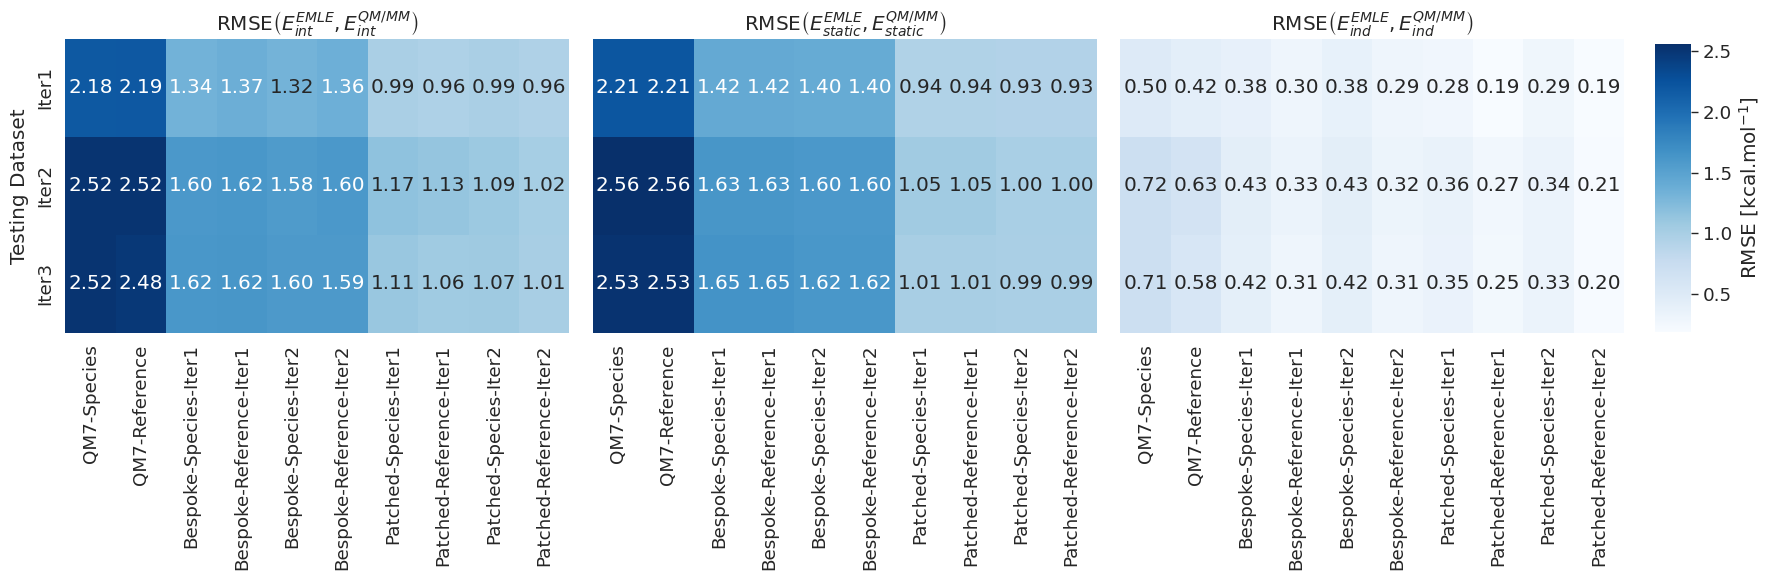

In [8]:
plot_metric_heatmap(
    df, metric="rmse", save_path=None, metric_label="RMSE"
)

# Mean Unsigned Error (MUE)

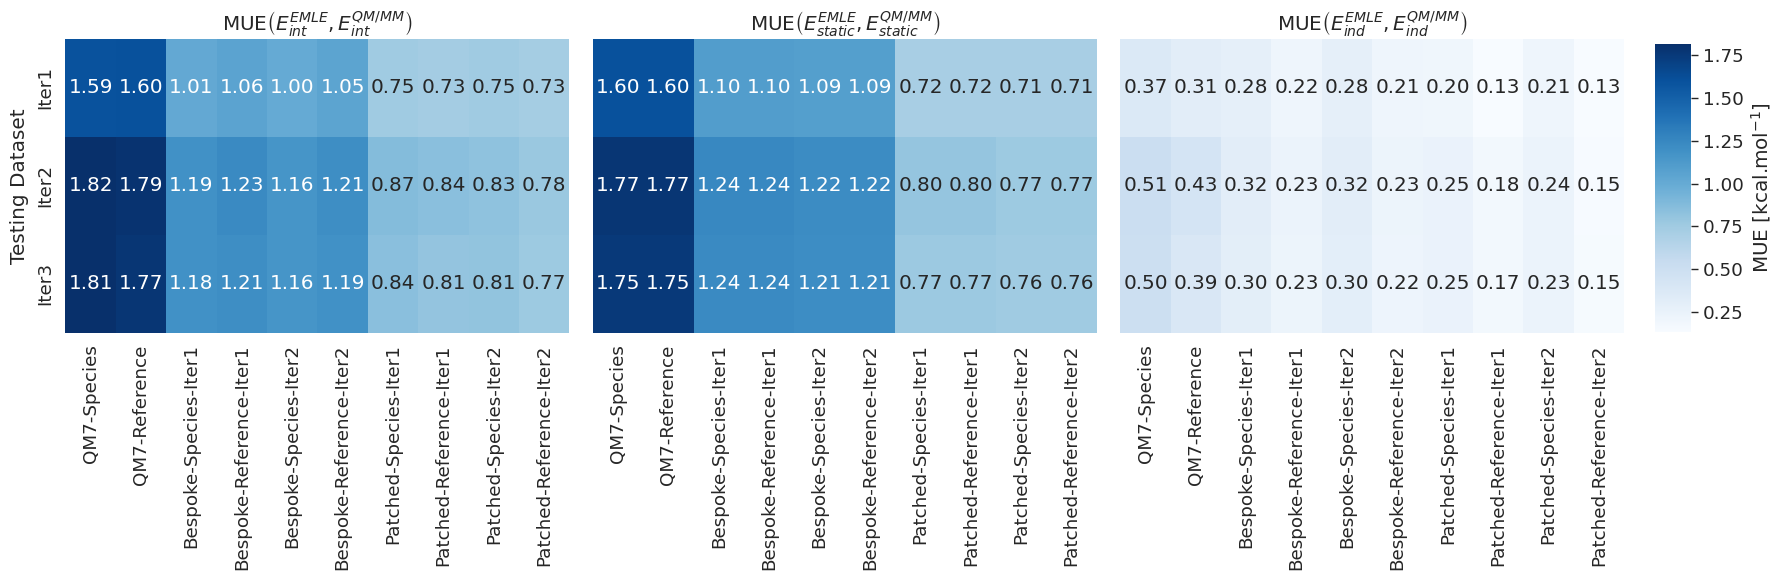

In [9]:
plot_metric_heatmap(
    df, metric="mue", save_path=None, metric_label="MUE"
)

# Mean Signed Error (MSE)

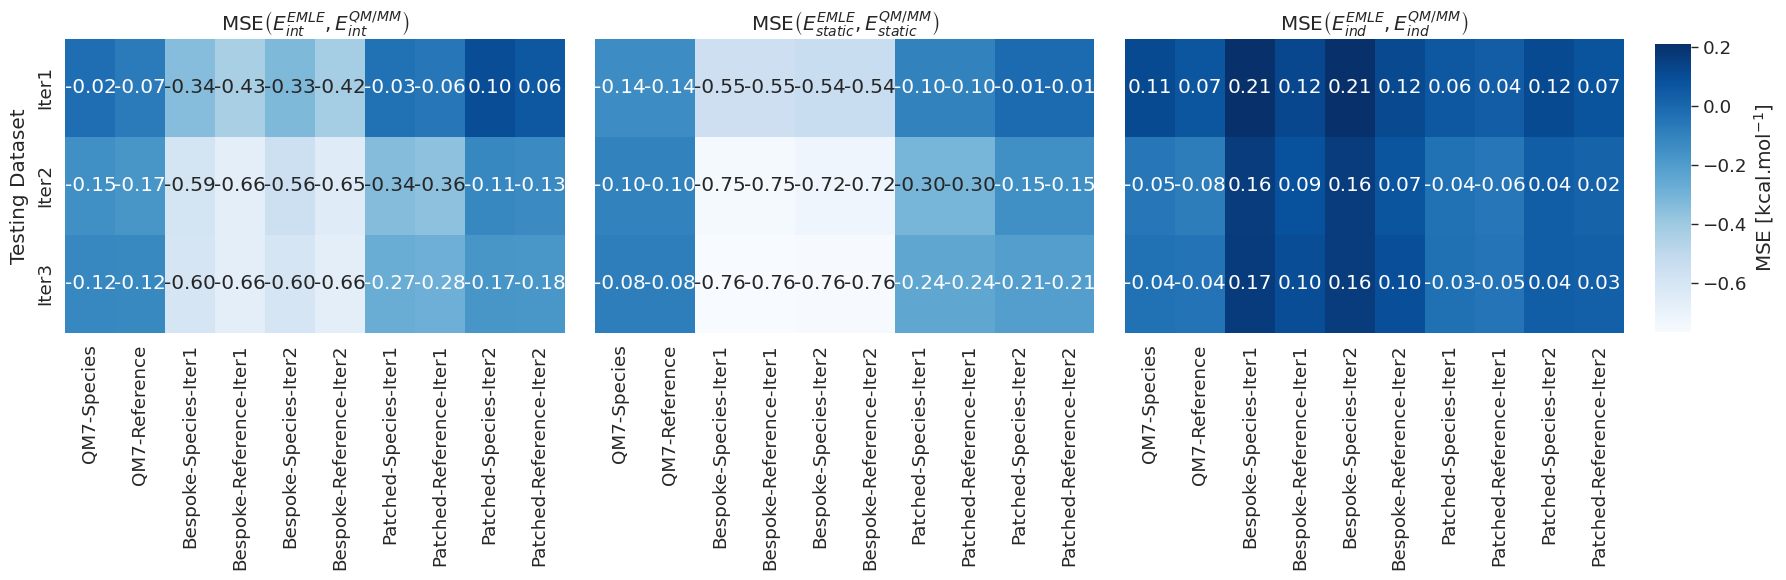

In [10]:
plot_metric_heatmap(
    df, metric="mse", save_path=None, metric_label="MSE"
)


# Kendall's tau

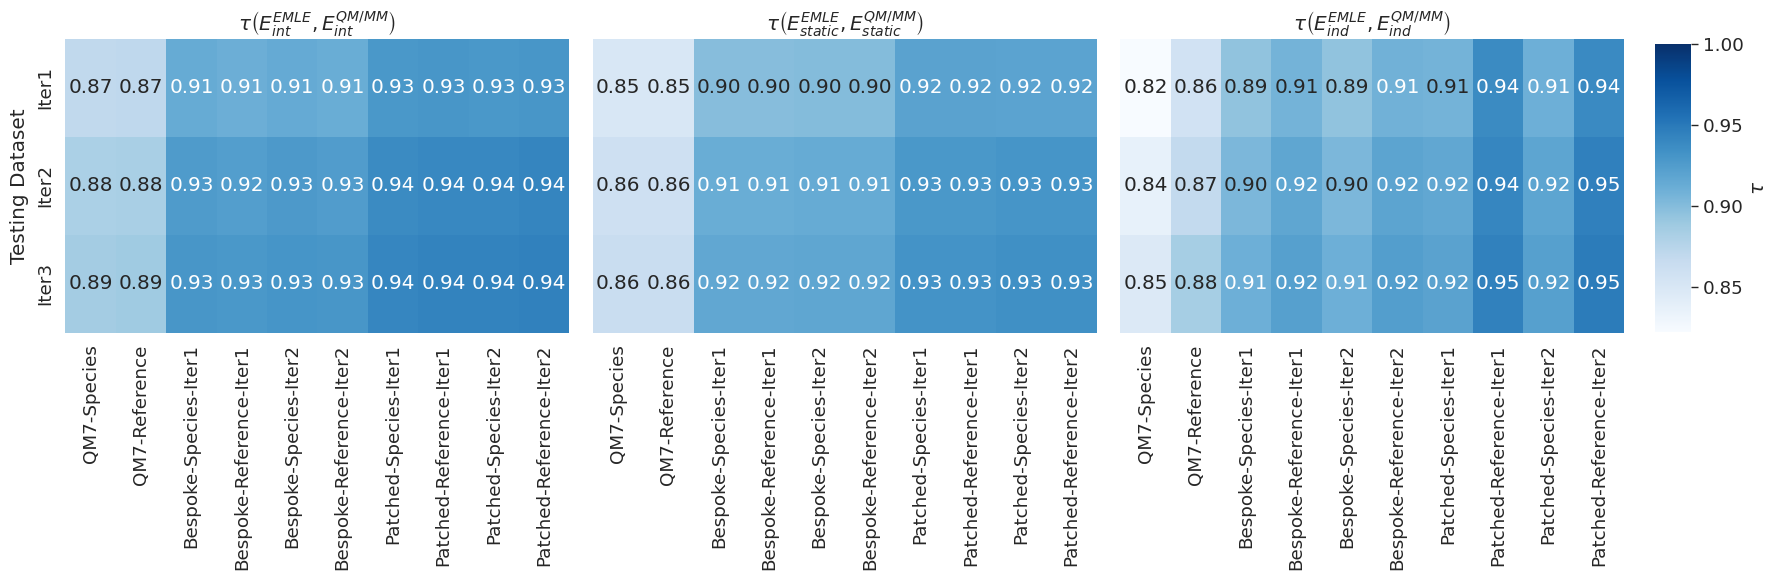

In [11]:
plot_metric_heatmap(
    df, metric="kendall", save_path=None, metric_label="$\\tau$"
)

# Pearson's rho

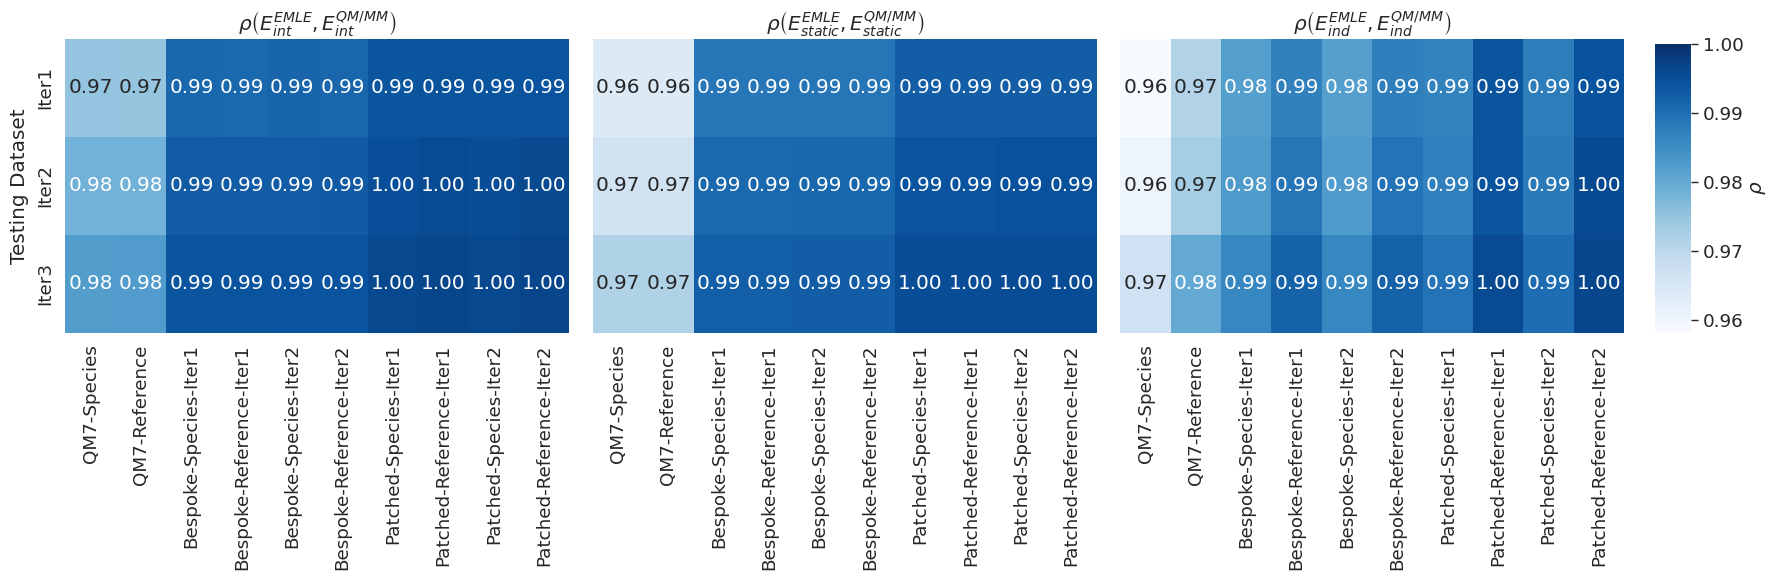

In [12]:
plot_metric_heatmap(
    df, metric="pearson", save_path=None, metric_label="$\\rho$"
)


# R2

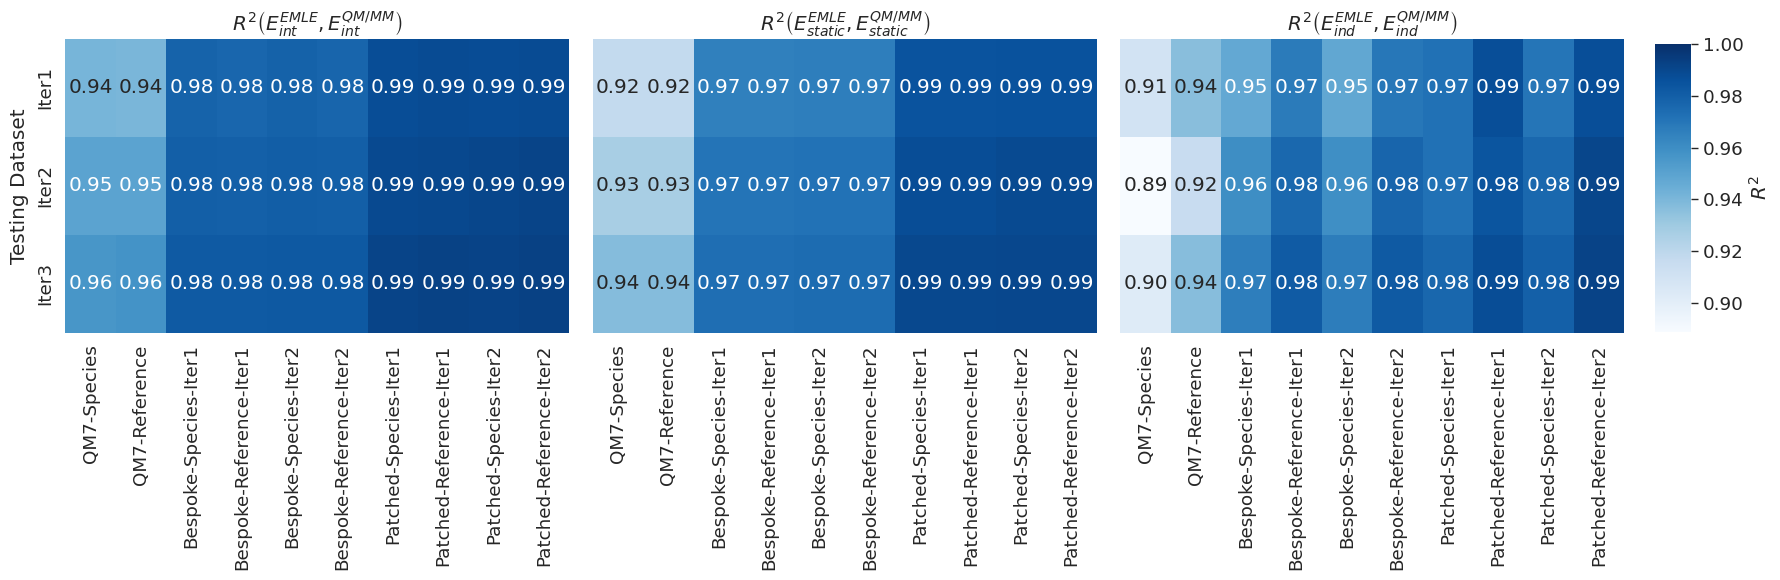

In [13]:
plot_metric_heatmap(
    df, metric="r2", save_path=None, metric_label="$R^2$"
)

# Unique plot 

In [14]:
def plot_multi_metric_heatmap(
    df,
    metrics,
    metric_labels=None,
    figsize=(20, 25),
    save_path=None,
    dpi=300,
):
    """
    Plot multiple heatmaps across metrics and energy components with custom styling.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with metrics data
    metrics : list of str
        List of metric keys (e.g., ['rmse', 'mue', 'r2'])
    metric_labels : list of str, optional
        Custom labels (for colorbars/titles). Defaults to upper(metrics[i]).
    figsize : tuple
        Size of the overall figure
    save_path : str
        Where to save the image
    dpi : int
        Dots per inch for saving
    """
    n_metrics = len(metrics)
    sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)
    fig, axes = plt.subplots(n_metrics, 3, figsize=figsize, sharex=True, sharey=True)

    cmap = sns.color_palette("Blues", as_cmap=True)
    metric_labels = metric_labels or [m.upper() for m in metrics]

    for i, metric in enumerate(metrics):
        # Extract metrics for each energy type
        df_total = df.applymap(lambda x: x[metric])["e_total"].reset_index()
        df_static = df.applymap(lambda x: x[metric])["e_static"].reset_index()
        df_ind = df.applymap(lambda x: x[metric])["e_ind"].reset_index()

        for df_metric in [df_total, df_static, df_ind]:
            df_metric["level_0"] = pd.Categorical(
                df_metric["level_0"], categories=df_metric["level_0"].unique(), ordered=True
            )
            df_metric["level_1"] = pd.Categorical(
                df_metric["level_1"], categories=df_metric["level_1"].unique(), ordered=True
            )
            df_metric.sort_values(by=["level_0", "level_1"], inplace=True)

        vmin = min(df_total["e_total"].min(), df_static["e_static"].min(), df_ind["e_ind"].min())
        vmax = max(df_total["e_total"].max(), df_static["e_static"].max(), df_ind["e_ind"].max())
        if metric in ["r2", "pearson", "kendall"]:
            vmax = 1

        cbar_label = metric_labels[i]
        if metric in ["rmse", "mse", "mue"]:
            cbar_label += r" [kcal.mol$^{-1}$]"

        # Titles with LaTeX style
        titles = [
            f"{metric_labels[i]}$\\left(E^{{EMLE}}_{{int}}, E^{{QM/MM}}_{{int}}\\right)$",
            f"{metric_labels[i]}$\\left(E^{{EMLE}}_{{static}}, E^{{QM/MM}}_{{static}}\\right)$",
            f"{metric_labels[i]}$\\left(E^{{EMLE}}_{{ind}}, E^{{QM/MM}}_{{ind}}\\right)$",
        ]

        for j, (df_metric, title, key) in enumerate(
            zip([df_total, df_static, df_ind], titles, ["e_total", "e_static", "e_ind"])
        ):
            ax = axes[i][j] if n_metrics > 1 else axes[j]
            sns.heatmap(
                df_metric.pivot(index="level_0", columns="level_1", values=key),
                annot=True,
                fmt=".2f",
                ax=ax,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                cbar=(j == 2),
                cbar_kws={"label": cbar_label} if j == 2 else None,
            )

            ax.set_title(title, pad=5)
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.tick_params(axis="both", labelrotation=90)

            if j == 0:
                ax.set_ylabel("Testing Dataset", labelpad=5)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi)


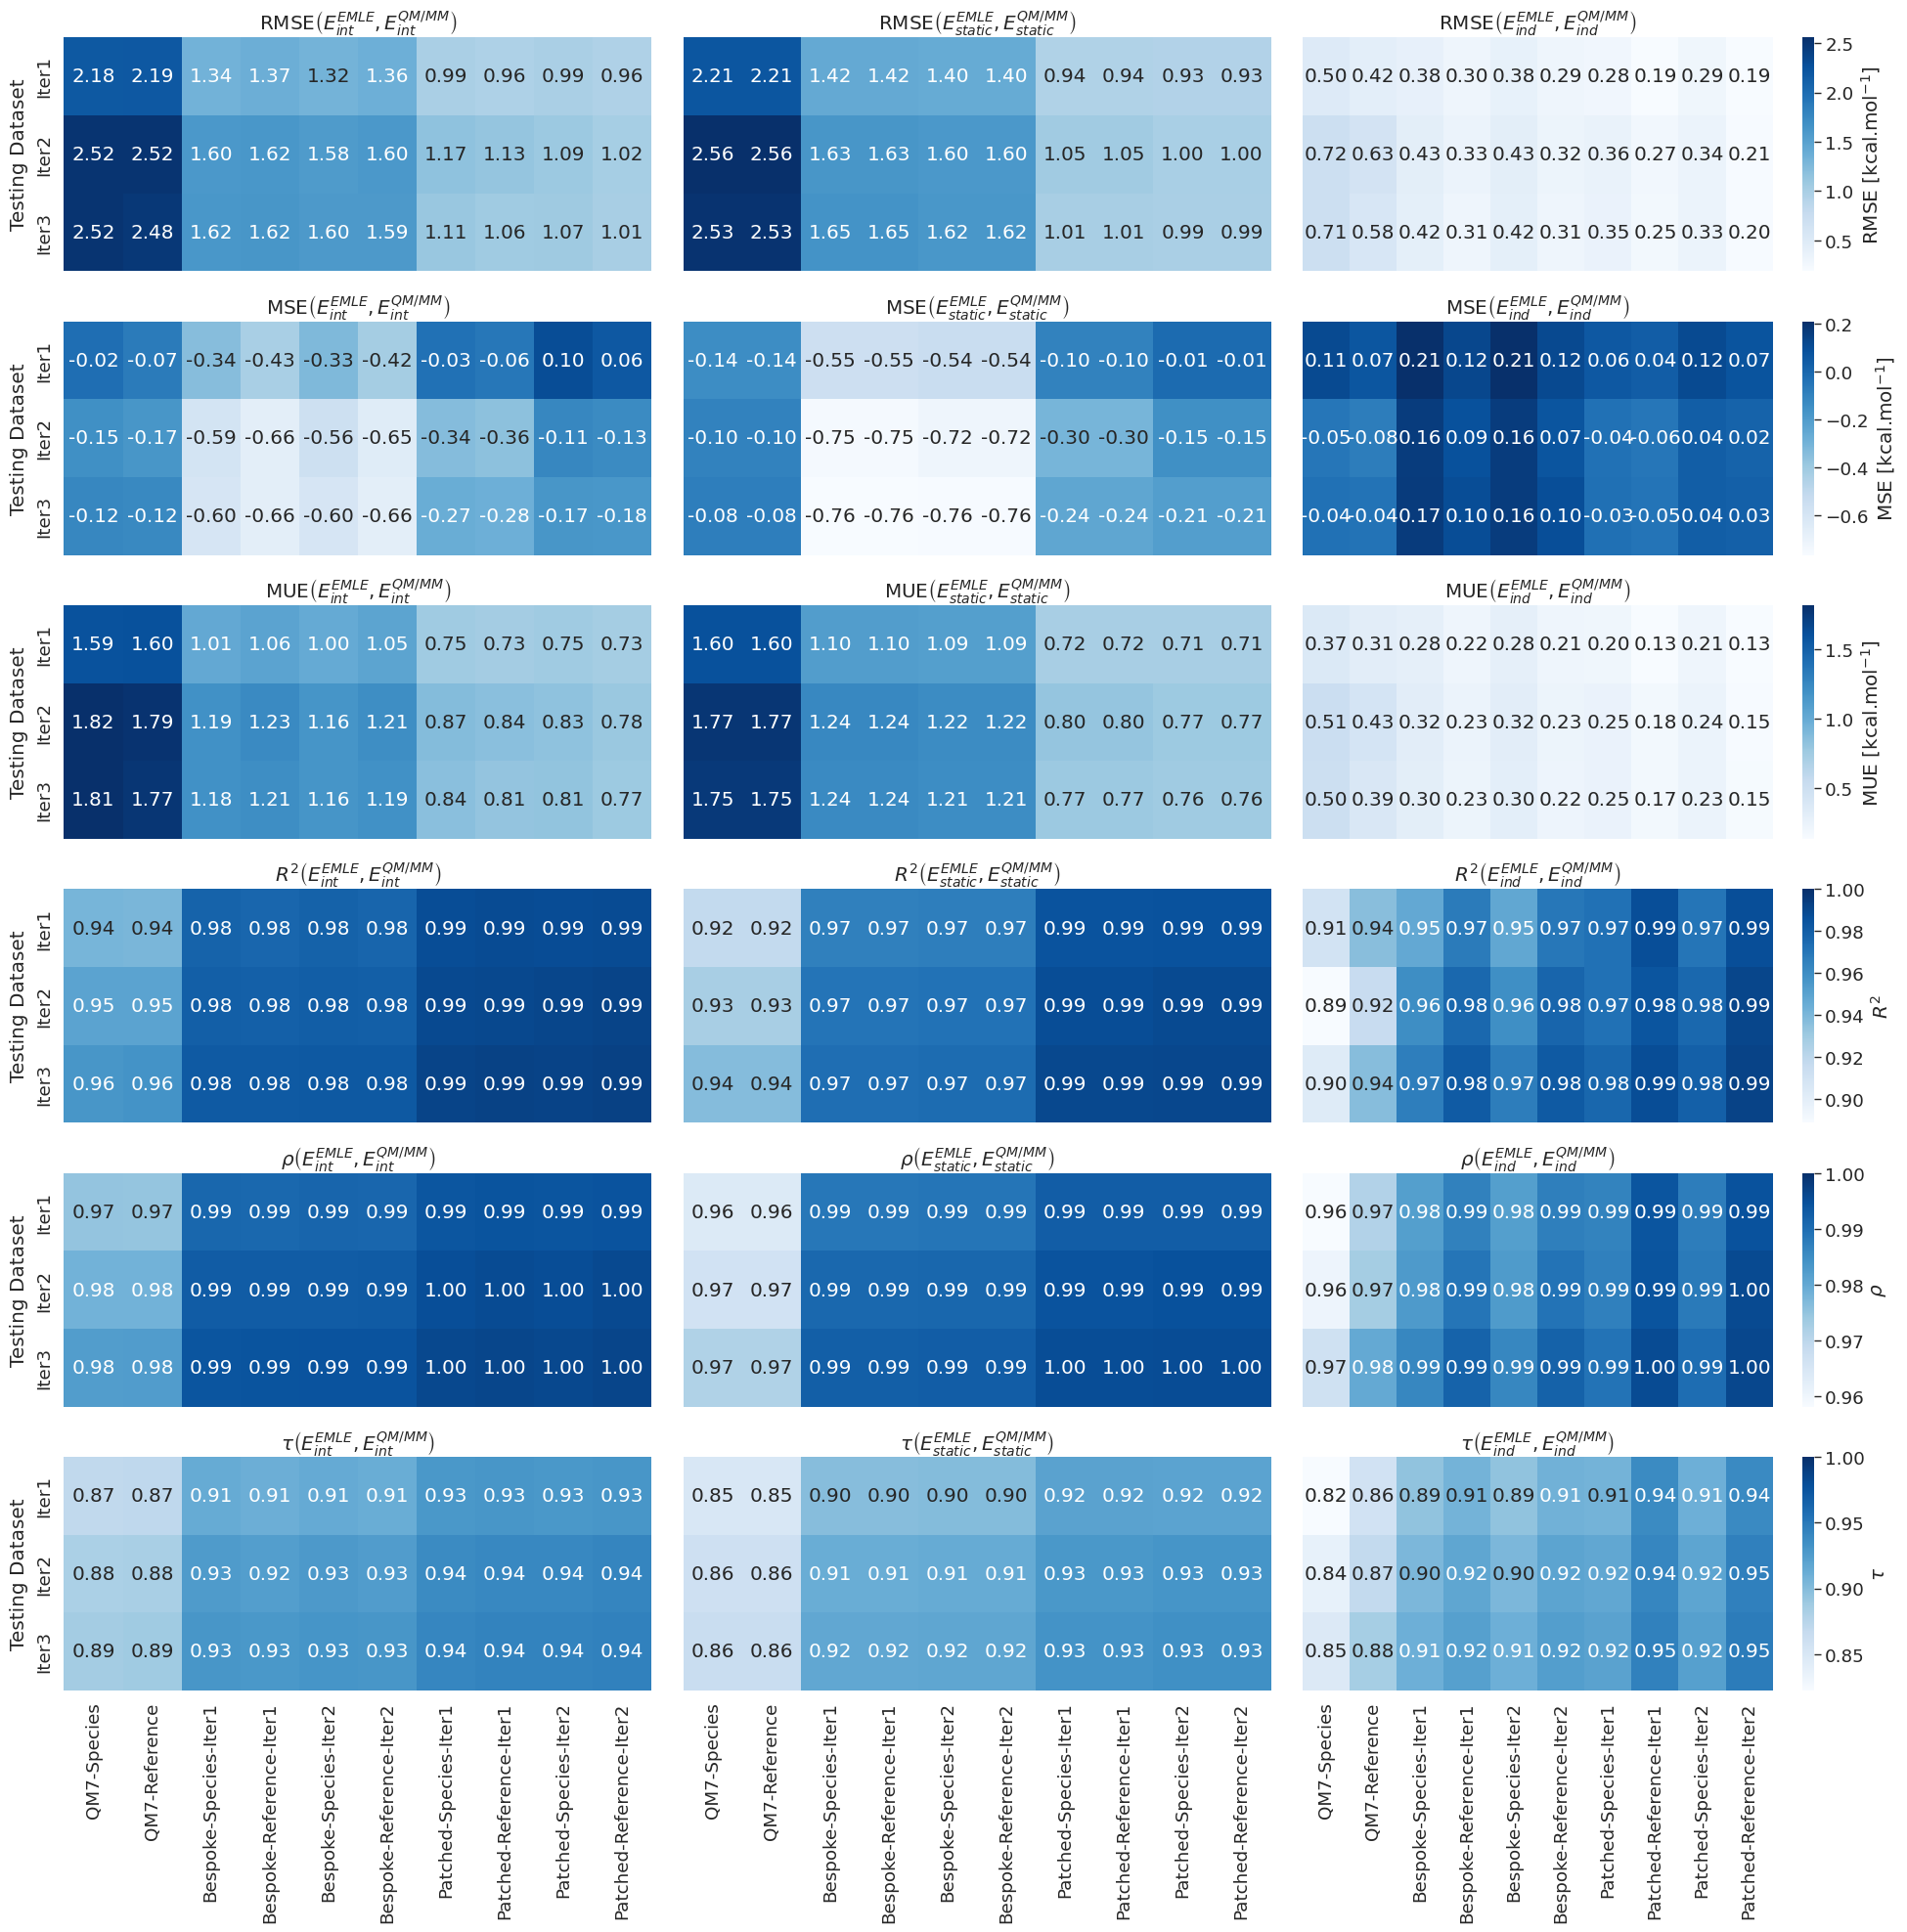

In [15]:
plot_multi_metric_heatmap(
    df,
    metrics=["rmse", "mse", "mue", "r2", "pearson", "kendall"],
    metric_labels=["RMSE", "MSE", "MUE", "$R^2$", "$\\rho$", "$\\tau$"],
    figsize=(20, 20),
    save_path="fig_all_metrics.pdf",
)